# Video Enhancement - Real-ESRGAN et Interpolation de Frames

**Module :** 01-Video-Foundation  
**Niveau :** Intermediaire  
**Technologies :** Real-ESRGAN, basicsr, RIFE (concept), imageio  
**Duree estimee :** 45 minutes  
**VRAM :** ~4 GB  

## Objectifs d'Apprentissage

- [ ] Creer une video basse resolution pour tester l'upscaling
- [ ] Appliquer Real-ESRGAN frame par frame (upscaling 2x et 4x)
- [ ] Comprendre le pipeline extract -> upscale -> reassemble
- [ ] Decouvrir le concept d'interpolation de frames (RIFE, 24fps -> 60fps)
- [ ] Calculer les metriques de qualite PSNR et SSIM
- [ ] Analyser le compromis qualite vs temps de traitement

## Prerequis

- GPU avec 4+ GB VRAM
- Notebook 01-1 (Video Operations Basics) complete
- Packages : `realesrgan`, `basicsr`, `torch`, `imageio`, `imageio-ffmpeg`, `scikit-image`

In [1]:
# Parametres Papermill - JAMAIS modifier ce commentaire

# Configuration notebook
notebook_mode = "interactive"        # "interactive" ou "batch"
skip_widgets = False               # True pour mode batch MCP
debug_level = "INFO"

# Parametres upscaling
scale_factor = 2                   # 2 ou 4
model_name = "RealESRGAN_x2plus"   # "RealESRGAN_x2plus" ou "RealESRGAN_x4plus"
tile_size = 256                    # Taille des tuiles (reduit la VRAM)

# Video de test
low_res_width = 160                # Largeur basse resolution
low_res_height = 120               # Hauteur basse resolution
test_fps = 12                      # FPS de la video de test
test_duration = 3                  # Duree en secondes

# Configuration
run_upscaling = True               # Executer l'upscaling
compute_metrics = True             # Calculer PSNR/SSIM
save_results = True

In [2]:
# Setup environnement et imports
import os
import sys
import time
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
import numpy as np
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
import logging

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Import helpers GenAI
GENAI_ROOT = Path.cwd()
while GENAI_ROOT.name != 'GenAI' and len(GENAI_ROOT.parts) > 1:
    GENAI_ROOT = GENAI_ROOT.parent

HELPERS_PATH = GENAI_ROOT / 'shared' / 'helpers'
if HELPERS_PATH.exists():
    sys.path.insert(0, str(HELPERS_PATH.parent))
    try:
        from helpers.genai_helpers import setup_genai_logging
        print("Helpers GenAI importes")
    except ImportError:
        print("Helpers GenAI non disponibles - mode autonome")

OUTPUT_DIR = GENAI_ROOT / 'outputs' / 'video_enhancement'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

logging.basicConfig(level=getattr(logging, debug_level))
logger = logging.getLogger('video_enhancement')

print(f"Video Enhancement - Real-ESRGAN")
print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}, Scale : {scale_factor}x, Modele : {model_name}")

Helpers GenAI importes
Video Enhancement - Real-ESRGAN
Date : 2026-02-18 10:29:47
Mode : interactive, Scale : 2x, Modele : RealESRGAN_x2plus


In [3]:
# Chargement .env et verification GPU
from dotenv import load_dotenv

current_path = Path.cwd()
found_env = False
for _ in range(4):
    env_path = current_path / '.env'
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Fichier .env charge depuis : {env_path}")
        found_env = True
        break
    current_path = current_path.parent

if not found_env:
    print("Aucun fichier .env trouve")

# Verification GPU
print("\n--- VERIFICATION GPU ET DEPENDANCES ---")
print("=" * 45)

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    vram_total = torch.cuda.get_device_properties(0).total_mem / 1024**3
    print(f"GPU : {gpu_name}")
    print(f"VRAM : {vram_total:.1f} GB")
else:
    print("Pas de GPU. L'upscaling sera tres lent en mode CPU.")

# Verification Real-ESRGAN
esrgan_available = False
try:
    from realesrgan import RealESRGANer
    from basicsr.archs.rrdbnet_arch import RRDBNet
    esrgan_available = True
    print(f"Real-ESRGAN : disponible")
except ImportError as e:
    print(f"Real-ESRGAN : NON INSTALLE")
    print(f"  pip install realesrgan basicsr")
    print(f"  Erreur : {e}")

# Verification imageio
import imageio
print(f"imageio : v{imageio.__version__}")

# Verification scikit-image pour metriques
metrics_available = False
try:
    from skimage.metrics import peak_signal_noise_ratio, structural_similarity
    metrics_available = True
    print(f"scikit-image : disponible (metriques PSNR/SSIM)")
except ImportError:
    print(f"scikit-image : NON INSTALLE (pip install scikit-image)")
    print(f"  Metriques PSNR/SSIM non disponibles")

Fichier .env charge depuis : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\.env

--- VERIFICATION GPU ET DEPENDANCES ---


Pas de GPU. L'upscaling sera tres lent en mode CPU.
Real-ESRGAN : NON INSTALLE
  pip install realesrgan basicsr
  Erreur : No module named 'realesrgan'
imageio : v2.37.2


scikit-image : disponible (metriques PSNR/SSIM)


## Section 1 : Creation d'une video basse resolution

Pour tester l'upscaling, nous creons d'abord une video "haute resolution" de reference,
puis nous la degradons en basse resolution. Cela nous permet de comparer objectivement
la version upscalee avec l'originale (calcul PSNR et SSIM).


--- CREATION DES VIDEOS DE TEST ---
Resolution basse : 160x120
Resolution haute (reference) : 320x240
Frames : 36, FPS : 12
Video HR sauvegardee : reference_hr.mp4 (36.4 KB)


Video LR sauvegardee : input_lr.mp4 (17.1 KB)


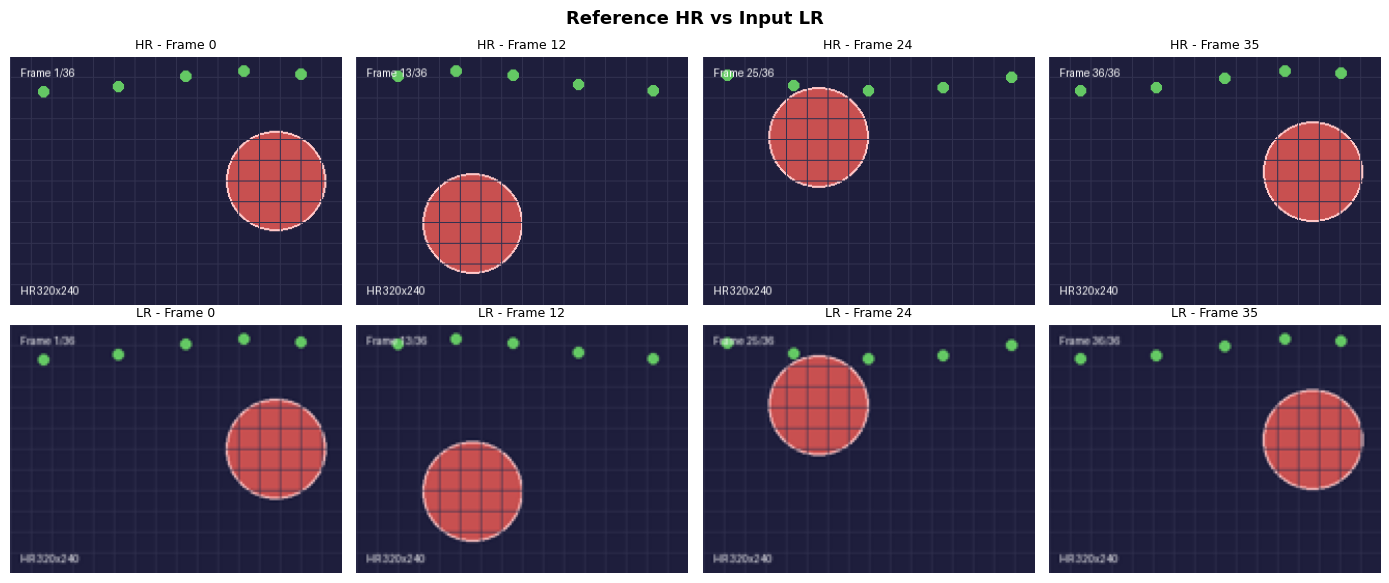

In [4]:
# Creation de videos de reference et basse resolution
print("\n--- CREATION DES VIDEOS DE TEST ---")
print("=" * 40)

# Resolution haute (reference)
hr_width = low_res_width * scale_factor
hr_height = low_res_height * scale_factor
n_frames = test_fps * test_duration

print(f"Resolution basse : {low_res_width}x{low_res_height}")
print(f"Resolution haute (reference) : {hr_width}x{hr_height}")
print(f"Frames : {n_frames}, FPS : {test_fps}")

# Generer les frames haute resolution
hr_frames = []
lr_frames = []

for i in range(n_frames):
    t = i / n_frames
    
    # Image HD avec details fins
    img_hr = Image.new('RGB', (hr_width, hr_height), (30, 30, 60))
    draw = ImageDraw.Draw(img_hr)
    
    # Formes avec details fins
    cx = int(hr_width * 0.5 + hr_width * 0.3 * np.cos(2 * np.pi * t))
    cy = int(hr_height * 0.5 + hr_height * 0.2 * np.sin(2 * np.pi * t))
    
    # Cercle principal
    r = hr_height // 5
    draw.ellipse([cx-r, cy-r, cx+r, cy+r], fill=(200, 80, 80), outline=(255, 200, 200), width=2)
    
    # Grille de fond (details fins pour tester la super-resolution)
    for gx in range(0, hr_width, 20):
        draw.line([(gx, 0), (gx, hr_height)], fill=(50, 50, 80), width=1)
    for gy in range(0, hr_height, 20):
        draw.line([(0, gy), (hr_width, gy)], fill=(50, 50, 80), width=1)
    
    # Petits cercles decoratifs
    for j in range(5):
        sx = int(hr_width * (0.1 + 0.2 * j) + 10 * np.sin(2 * np.pi * t + j))
        sy = int(hr_height * 0.1 + 10 * np.cos(2 * np.pi * t + j))
        draw.ellipse([sx-5, sy-5, sx+5, sy+5], fill=(100, 200, 100))
    
    # Texte
    draw.text((10, 10), f"Frame {i+1}/{n_frames}", fill='white')
    draw.text((10, hr_height - 20), f"HR {hr_width}x{hr_height}", fill='white')
    
    hr_frames.append(np.array(img_hr))
    
    # Version basse resolution (downscale)
    img_lr = img_hr.resize((low_res_width, low_res_height), Image.Resampling.BICUBIC)
    lr_frames.append(np.array(img_lr))

# Sauvegarde des deux videos
hr_video_path = OUTPUT_DIR / "reference_hr.mp4"
lr_video_path = OUTPUT_DIR / "input_lr.mp4"

for frames, path, label in [(hr_frames, hr_video_path, "HR"), (lr_frames, lr_video_path, "LR")]:
    writer = imageio.get_writer(str(path), fps=test_fps, codec='libx264')
    for frame in frames:
        writer.append_data(frame)
    writer.close()
    size_kb = path.stat().st_size / 1024
    print(f"Video {label} sauvegardee : {path.name} ({size_kb:.1f} KB)")

# Apercu comparatif
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
preview_indices = [0, n_frames // 3, 2 * n_frames // 3, n_frames - 1]
for i, idx in enumerate(preview_indices):
    axes[0, i].imshow(hr_frames[idx])
    axes[0, i].set_title(f"HR - Frame {idx}", fontsize=9)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(lr_frames[idx])
    axes[1, i].set_title(f"LR - Frame {idx}", fontsize=9)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel(f"HR\n{hr_width}x{hr_height}", fontsize=10, fontweight='bold')
axes[1, 0].set_ylabel(f"LR\n{low_res_width}x{low_res_height}", fontsize=10, fontweight='bold')
plt.suptitle("Reference HR vs Input LR", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Section 2 : Upscaling frame par frame avec Real-ESRGAN

Le pipeline d'upscaling video est :
1. **Extraire** les frames de la video basse resolution
2. **Upscaler** chaque frame avec Real-ESRGAN
3. **Reassembler** les frames upscalees en video

Real-ESRGAN utilise un reseau RRDB (Residual-in-Residual Dense Block) entraine
sur des paires d'images haute/basse resolution.

In [5]:
# Upscaling avec Real-ESRGAN
sr_frames = []

if run_upscaling and esrgan_available:
    print("\n--- UPSCALING REAL-ESRGAN ---")
    print("=" * 40)
    
    # Configuration du modele
    if scale_factor == 2:
        esrgan_model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64,
                               num_block=23, num_grow_ch=32, scale=2)
        model_url = 'https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth'
    else:
        esrgan_model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64,
                               num_block=23, num_grow_ch=32, scale=4)
        model_url = 'https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth'
    
    # Initialisation upsampler
    upsampler = RealESRGANer(
        scale=scale_factor,
        model_path=model_url,
        model=esrgan_model,
        tile=tile_size,
        tile_pad=10,
        pre_pad=0,
        half=True if device == "cuda" else False,
        device=device
    )
    
    print(f"Modele : {model_name}")
    print(f"Scale : {scale_factor}x")
    print(f"Tile : {tile_size}")
    print(f"Device : {device}")
    print(f"\nUpscaling de {len(lr_frames)} frames...")
    
    # Upscaling frame par frame
    start_time = time.time()
    frame_times = []
    
    for i, lr_frame in enumerate(lr_frames):
        frame_start = time.time()
        
        # Real-ESRGAN attend un array BGR (OpenCV convention)
        import cv2
        lr_bgr = cv2.cvtColor(lr_frame, cv2.COLOR_RGB2BGR)
        sr_bgr, _ = upsampler.enhance(lr_bgr, outscale=scale_factor)
        sr_rgb = cv2.cvtColor(sr_bgr, cv2.COLOR_BGR2RGB)
        
        sr_frames.append(sr_rgb)
        frame_time = time.time() - frame_start
        frame_times.append(frame_time)
        
        if (i + 1) % 10 == 0 or i == 0:
            print(f"  Frame {i+1}/{len(lr_frames)} : {frame_time*1000:.0f}ms")
    
    total_time = time.time() - start_time
    avg_time = np.mean(frame_times)
    
    print(f"\nUpscaling termine")
    print(f"  Temps total : {total_time:.1f}s")
    print(f"  Temps moyen/frame : {avg_time*1000:.0f}ms")
    print(f"  Resolution sortie : {sr_frames[0].shape[1]}x{sr_frames[0].shape[0]}")
    
    # Sauvegarder la video upscalee
    sr_video_path = OUTPUT_DIR / f"upscaled_{scale_factor}x.mp4"
    writer = imageio.get_writer(str(sr_video_path), fps=test_fps, codec='libx264')
    for frame in sr_frames:
        writer.append_data(frame)
    writer.close()
    
    sr_size_kb = sr_video_path.stat().st_size / 1024
    print(f"  Video sauvegardee : {sr_video_path.name} ({sr_size_kb:.1f} KB)")
    
elif not esrgan_available:
    print("Real-ESRGAN non installe - upscaling ignore")
    print("Simulation avec resize bicubique pour la suite du notebook")
    
    # Fallback : upscale bicubique (pour que le reste du notebook fonctionne)
    for lr_frame in lr_frames:
        img = Image.fromarray(lr_frame)
        img_up = img.resize((hr_width, hr_height), Image.Resampling.BICUBIC)
        sr_frames.append(np.array(img_up))
    
    sr_video_path = OUTPUT_DIR / f"upscaled_bicubic_{scale_factor}x.mp4"
    writer = imageio.get_writer(str(sr_video_path), fps=test_fps, codec='libx264')
    for frame in sr_frames:
        writer.append_data(frame)
    writer.close()
    print(f"Video bicubique sauvegardee : {sr_video_path.name}")
else:
    print("Upscaling desactive (run_upscaling=False)")

Real-ESRGAN non installe - upscaling ignore
Simulation avec resize bicubique pour la suite du notebook
Video bicubique sauvegardee : upscaled_bicubic_2x.mp4



--- COMPARAISON ET METRIQUES ---


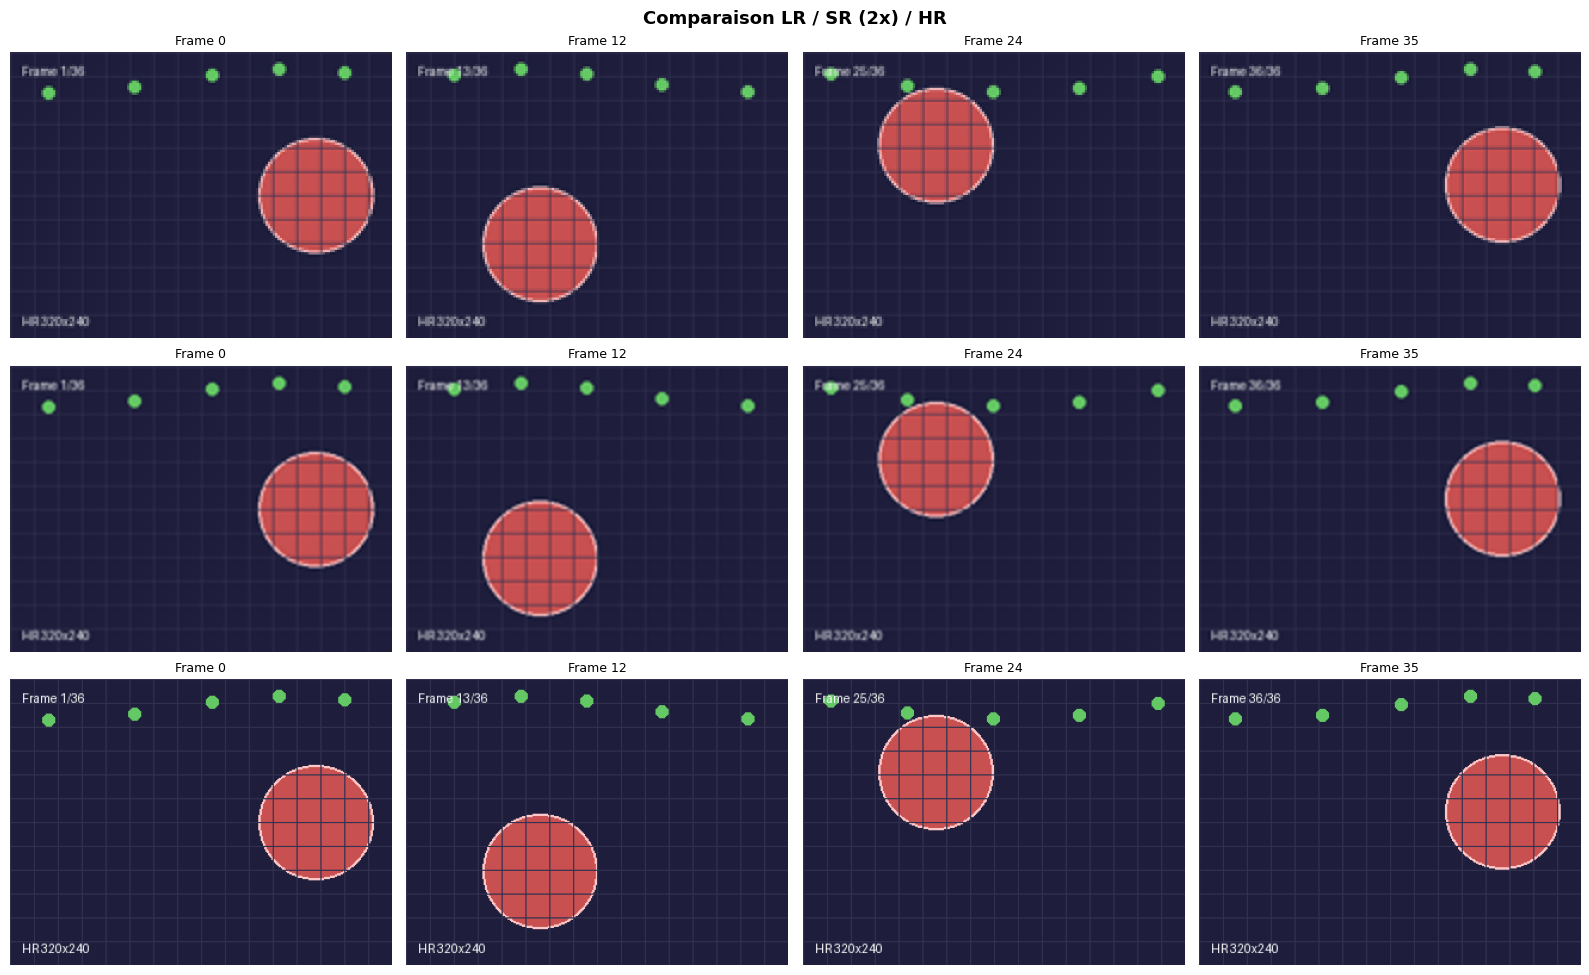


Calcul des metriques PSNR et SSIM...



Resultats metriques :
Metrique        Moyenne      Min          Max         
--------------------------------------------------
PSNR (dB)       26.33        26.20        26.45       
SSIM            0.8243       0.8235       0.8250      

Interpretation :
  PSNR 26.3 dB : Qualite acceptable
  SSIM 0.8243 : Bonne similarite


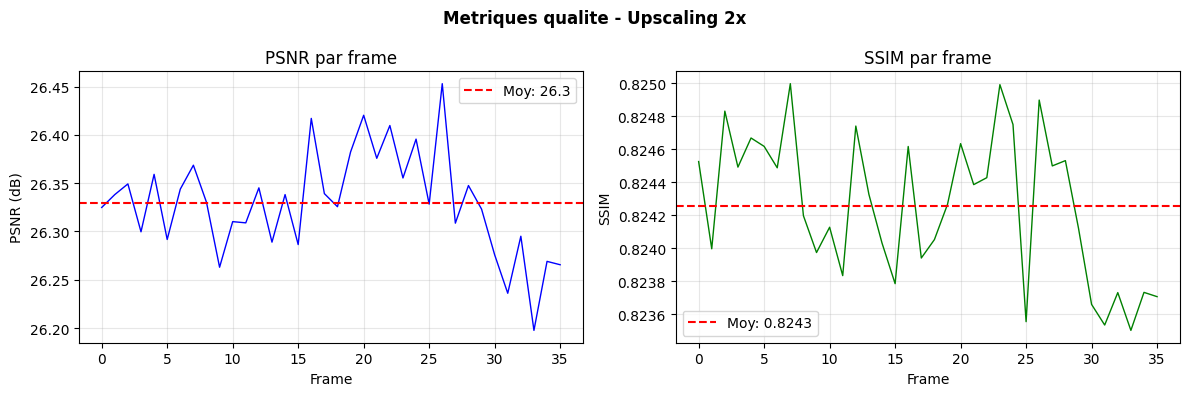

In [6]:
# Comparaison visuelle et metriques de qualite
print("\n--- COMPARAISON ET METRIQUES ---")
print("=" * 40)

if sr_frames:
    # Comparaison visuelle LR vs SR vs HR
    fig, axes = plt.subplots(3, 4, figsize=(16, 10))
    preview_indices = [0, n_frames // 3, 2 * n_frames // 3, n_frames - 1]
    
    for i, idx in enumerate(preview_indices):
        # LR (upscalee en bicubique pour meme taille d'affichage)
        lr_display = Image.fromarray(lr_frames[idx]).resize((hr_width, hr_height), Image.Resampling.NEAREST)
        axes[0, i].imshow(np.array(lr_display))
        axes[0, i].set_title(f"Frame {idx}", fontsize=9)
        axes[0, i].axis('off')
        
        # SR
        axes[1, i].imshow(sr_frames[idx])
        axes[1, i].set_title(f"Frame {idx}", fontsize=9)
        axes[1, i].axis('off')
        
        # HR reference
        axes[2, i].imshow(hr_frames[idx])
        axes[2, i].set_title(f"Frame {idx}", fontsize=9)
        axes[2, i].axis('off')
    
    axes[0, 0].set_ylabel(f"LR\n{low_res_width}x{low_res_height}", fontsize=10, fontweight='bold')
    axes[1, 0].set_ylabel(f"SR {scale_factor}x\n{sr_frames[0].shape[1]}x{sr_frames[0].shape[0]}",
                          fontsize=10, fontweight='bold')
    axes[2, 0].set_ylabel(f"HR (ref)\n{hr_width}x{hr_height}", fontsize=10, fontweight='bold')
    plt.suptitle(f"Comparaison LR / SR ({scale_factor}x) / HR", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Metriques PSNR et SSIM
    if compute_metrics and metrics_available and len(sr_frames) > 0:
        print("\nCalcul des metriques PSNR et SSIM...")
        psnr_values = []
        ssim_values = []
        
        for i in range(min(len(sr_frames), len(hr_frames))):
            sr_f = sr_frames[i]
            hr_f = hr_frames[i]
            
            # Ajuster les dimensions si necessaire
            if sr_f.shape != hr_f.shape:
                sr_img = Image.fromarray(sr_f).resize((hr_width, hr_height), Image.Resampling.LANCZOS)
                sr_f = np.array(sr_img)
            
            psnr_val = peak_signal_noise_ratio(hr_f, sr_f)
            ssim_val = structural_similarity(hr_f, sr_f, channel_axis=2, data_range=255)
            psnr_values.append(psnr_val)
            ssim_values.append(ssim_val)
        
        avg_psnr = np.mean(psnr_values)
        avg_ssim = np.mean(ssim_values)
        
        print(f"\nResultats metriques :")
        print(f"{'Metrique':<15} {'Moyenne':<12} {'Min':<12} {'Max':<12}")
        print("-" * 50)
        print(f"{'PSNR (dB)':<15} {avg_psnr:<12.2f} {min(psnr_values):<12.2f} {max(psnr_values):<12.2f}")
        print(f"{'SSIM':<15} {avg_ssim:<12.4f} {min(ssim_values):<12.4f} {max(ssim_values):<12.4f}")
        
        # Interpretation
        print(f"\nInterpretation :")
        if avg_psnr > 30:
            print(f"  PSNR {avg_psnr:.1f} dB : Bonne qualite de reconstruction")
        elif avg_psnr > 25:
            print(f"  PSNR {avg_psnr:.1f} dB : Qualite acceptable")
        else:
            print(f"  PSNR {avg_psnr:.1f} dB : Qualite a ameliorer")
        
        if avg_ssim > 0.9:
            print(f"  SSIM {avg_ssim:.4f} : Excellente similarite structurelle")
        elif avg_ssim > 0.8:
            print(f"  SSIM {avg_ssim:.4f} : Bonne similarite")
        else:
            print(f"  SSIM {avg_ssim:.4f} : Similarite moderee")
        
        # Graphique evolution metriques
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.plot(psnr_values, 'b-', linewidth=1)
        ax1.axhline(y=avg_psnr, color='r', linestyle='--', label=f'Moy: {avg_psnr:.1f}')
        ax1.set_xlabel('Frame')
        ax1.set_ylabel('PSNR (dB)')
        ax1.set_title('PSNR par frame')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(ssim_values, 'g-', linewidth=1)
        ax2.axhline(y=avg_ssim, color='r', linestyle='--', label=f'Moy: {avg_ssim:.4f}')
        ax2.set_xlabel('Frame')
        ax2.set_ylabel('SSIM')
        ax2.set_title('SSIM par frame')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.suptitle(f"Metriques qualite - Upscaling {scale_factor}x", fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
    elif not metrics_available:
        print("scikit-image non disponible - metriques non calculees")
else:
    print("Pas de frames upscalees disponibles")

### Interpretation : Metriques de qualite

| Metrique | Plage | Signification |
|----------|-------|---------------|
| **PSNR** | 0 - inf dB | Plus c'est eleve, meilleure est la qualite. >30 dB = bon, >40 dB = excellent |
| **SSIM** | 0 - 1 | Similarite structurelle percue. >0.9 = excellent, >0.8 = bon |

**Limites de ces metriques** :
- PSNR mesure la difference pixel a pixel : ne capture pas la qualite percue
- SSIM est meilleur pour la perception humaine mais reste imparfait
- Real-ESRGAN peut generer des details qui n'existent pas dans la reference (hallucinations)

## Section 3 : Concept d'interpolation de frames (RIFE)

RIFE (Real-Time Intermediate Flow Estimation) permet de generer des frames
intermediaires pour augmenter le framerate d'une video (ex: 24fps -> 60fps).
Nous illustrons le concept avec une interpolation lineaire simple.


--- INTERPOLATION DE FRAMES (CONCEPT) ---


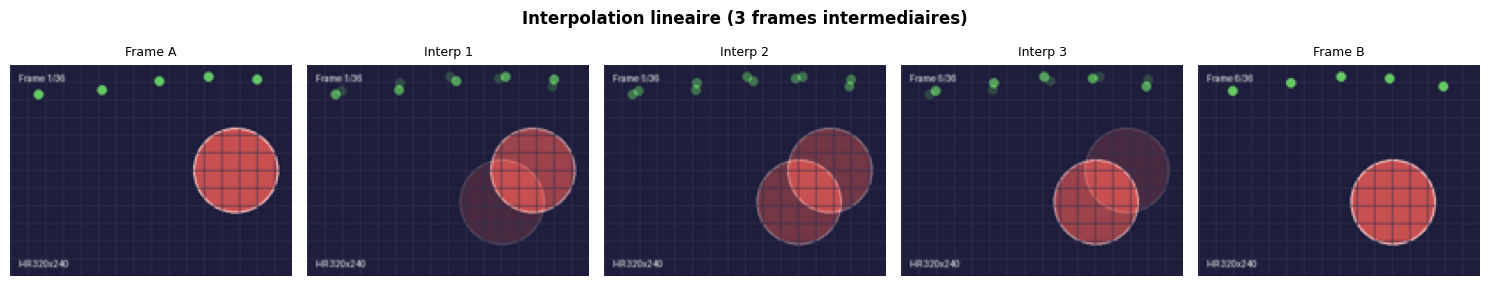


Comparaison des methodes d'interpolation :

Methode                   Qualite         Vitesse         VRAM      
-----------------------------------------------------------------
Lineaire (blend)          Faible          Instantanee     0 MB      
RIFE (flux optique)       Excellente      ~50ms/frame     ~2 GB     
Frame duplication         Nulle           Instantanee     0 MB      

L'interpolation lineaire produit des artefacts de transparence (ghosting).
RIFE estime le mouvement entre frames et genere des intermediaires realistes.
Application typique : convertir 24fps en 60fps pour un rendu plus fluide.


In [7]:
# Concept d'interpolation de frames
print("\n--- INTERPOLATION DE FRAMES (CONCEPT) ---")
print("=" * 45)

def interpolate_frames_linear(frame_a: np.ndarray, frame_b: np.ndarray,
                               n_intermediate: int = 1) -> List[np.ndarray]:
    """
    Interpolation lineaire simple entre deux frames.
    Ceci est une demonstration du concept ; RIFE utilise un reseau neuronal
    pour estimer le flux optique et generer des frames bien plus realistes.
    """
    result = []
    for i in range(1, n_intermediate + 1):
        alpha = i / (n_intermediate + 1)
        interpolated = ((1 - alpha) * frame_a.astype(float) +
                        alpha * frame_b.astype(float)).astype(np.uint8)
        result.append(interpolated)
    return result

# Demonstration : interpoler entre 2 frames
frame_a = lr_frames[0]
frame_b = lr_frames[min(5, len(lr_frames) - 1)]
n_inter = 3

interpolated = interpolate_frames_linear(frame_a, frame_b, n_inter)
all_display = [frame_a] + interpolated + [frame_b]

fig, axes = plt.subplots(1, len(all_display), figsize=(3 * len(all_display), 3))
labels = ["Frame A"] + [f"Interp {i+1}" for i in range(n_inter)] + ["Frame B"]
for ax, frame, label in zip(axes, all_display, labels):
    ax.imshow(frame)
    ax.set_title(label, fontsize=9)
    ax.axis('off')
plt.suptitle(f"Interpolation lineaire ({n_inter} frames intermediaires)",
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Explication RIFE vs interpolation lineaire
print(f"\nComparaison des methodes d'interpolation :")
print(f"")
print(f"{'Methode':<25} {'Qualite':<15} {'Vitesse':<15} {'VRAM':<10}")
print("-" * 65)
print(f"{'Lineaire (blend)':<25} {'Faible':<15} {'Instantanee':<15} {'0 MB':<10}")
print(f"{'RIFE (flux optique)':<25} {'Excellente':<15} {'~50ms/frame':<15} {'~2 GB':<10}")
print(f"{'Frame duplication':<25} {'Nulle':<15} {'Instantanee':<15} {'0 MB':<10}")
print(f"")
print(f"L'interpolation lineaire produit des artefacts de transparence (ghosting).")
print(f"RIFE estime le mouvement entre frames et genere des intermediaires realistes.")
print(f"Application typique : convertir 24fps en 60fps pour un rendu plus fluide.")

In [8]:
# Mode interactif
if notebook_mode == "interactive" and not skip_widgets:
    print("\n--- MODE INTERACTIF ---")
    print("=" * 40)
    print("Entrez un chemin vers une video pour l'upscaler.")
    print("(Laissez vide pour passer a la suite)")
    
    try:
        user_video = input("\nChemin video (ou vide) : ").strip()
        
        if user_video and Path(user_video).exists() and esrgan_available:
            import decord
            decord.bridge.set_bridge('native')
            vr = decord.VideoReader(user_video)
            
            # Extraire et upscaler quelques frames
            indices = np.linspace(0, len(vr) - 1, 4, dtype=int).tolist()
            user_frames = vr.get_batch(indices).asnumpy()
            
            print(f"Upscaling de {len(indices)} frames...")
            for i, frame in enumerate(user_frames):
                import cv2
                bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                sr_bgr, _ = upsampler.enhance(bgr, outscale=scale_factor)
                sr_rgb = cv2.cvtColor(sr_bgr, cv2.COLOR_BGR2RGB)
                print(f"  Frame {i+1}: {frame.shape[:2]} -> {sr_rgb.shape[:2]}")
            print("Upscaling termine")
        elif user_video:
            print(f"Fichier non trouve ou Real-ESRGAN non disponible")
        else:
            print("Mode interactif ignore")
    
    except (KeyboardInterrupt, EOFError) as e:
        print(f"\nMode interactif interrompu ({type(e).__name__})")
    except Exception as e:
        error_type = type(e).__name__
        if "StdinNotImplemented" in error_type or "input" in str(e).lower():
            print("\nMode interactif non disponible (execution automatisee)")
        else:
            print(f"\nErreur inattendue : {error_type} - {str(e)[:100]}")
            print("Passage a la suite du notebook")
else:
    print("\nMode batch - Interface interactive desactivee")


--- MODE INTERACTIF ---
Entrez un chemin vers une video pour l'upscaler.
(Laissez vide pour passer a la suite)

Mode interactif non disponible (execution automatisee)


## Bonnes pratiques et conseils d'optimisation

| Aspect | Recommandation | Raison |
|--------|---------------|--------|
| **Scale factor** | 2x sauf si necessaire | 4x quadruple le temps et la VRAM |
| **Tile size** | 256-512 | Plus petit = moins de VRAM, plus lent |
| **Codec sortie** | H.264 (libx264) | Meilleur compromis qualite/compatibilite |
| **Batch size** | 1 frame a la fois | Evite les OOM sur GPU |
| **Pre-processing** | Debruiter avant upscale | ESRGAN amplifie aussi le bruit |

**Quand utiliser l'upscaling** :
- Videos anciennes ou de faible resolution d'origine
- Preparation de contenu pour affichage haute resolution
- Post-production de videos generees par IA (souvent en faible resolution)

**Quand NE PAS utiliser l'upscaling** :
- Video deja en haute resolution
- Temps de traitement critique (streaming en temps reel)
- Quand la fidelite pixel-exact est requise (imagerie medicale, satellite)

In [9]:
# Statistiques de session et prochaines etapes
print("\n--- STATISTIQUES DE SESSION ---")
print("=" * 40)

print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}")
print(f"Scale factor : {scale_factor}x")
print(f"Modele : {model_name}")
print(f"Device : {device}")
print(f"Frames traitees : {len(sr_frames)}")

if save_results and OUTPUT_DIR.exists():
    generated_files = list(OUTPUT_DIR.glob('*'))
    print(f"\nFichiers generes ({len(generated_files)}) :")
    for f in sorted(generated_files):
        size_kb = f.stat().st_size / 1024
        print(f"  {f.name} ({size_kb:.1f} KB)")

print(f"\n--- PROCHAINES ETAPES ---")
print(f"1. Notebook 01-5 : Introduction a AnimateDiff (generation text-to-video)")
print(f"2. Combiner upscaling + generation pour des videos haute qualite")
print(f"3. Module 02 : Modeles generatifs video avances")

print(f"\nNotebook 01-4 Video Enhancement termine - {datetime.now().strftime('%H:%M:%S')}")


--- STATISTIQUES DE SESSION ---
Date : 2026-02-18 10:29:51
Mode : interactive
Scale factor : 2x
Modele : RealESRGAN_x2plus
Device : cpu
Frames traitees : 36

Fichiers generes (3) :
  input_lr.mp4 (17.1 KB)
  reference_hr.mp4 (36.4 KB)
  upscaled_bicubic_2x.mp4 (29.5 KB)

--- PROCHAINES ETAPES ---
1. Notebook 01-5 : Introduction a AnimateDiff (generation text-to-video)
2. Combiner upscaling + generation pour des videos haute qualite
3. Module 02 : Modeles generatifs video avances

Notebook 01-4 Video Enhancement termine - 10:29:51
